Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

pd.set_option("display.max_columns", 200)

Charger le dataset prêt

In [2]:
df = pd.read_parquet("data/processed/dataset_model.parquet")
df["start_date"] = pd.to_datetime(df["start_date"], utc=True)

TARGET = "pace_s_per_km"

FEATURES = [
    "distance_m",
    "elevation_gain_m",
    "elev_density_m_per_km",

    "dist_7d_m",
    "elev_7d_m",
    "time_7d_s",

    "dist_28d_m",
    "elev_28d_m",
    "time_28d_s",

    "charge_ratio_dist_7_28",
    "charge_ratio_elev_7_28",
    "charge_ratio_time_7_28",

    "log_distance_m",
    "log_elev_gain_m",
]

df.shape, FEATURES

((28, 26),
 ['distance_m',
  'elevation_gain_m',
  'elev_density_m_per_km',
  'dist_7d_m',
  'elev_7d_m',
  'time_7d_s',
  'dist_28d_m',
  'elev_28d_m',
  'time_28d_s',
  'charge_ratio_dist_7_28',
  'charge_ratio_elev_7_28',
  'charge_ratio_time_7_28',
  'log_distance_m',
  'log_elev_gain_m'])

Split temporel (obligatoire)

In [3]:
# split par quantile temporel (80/20)
split_date = df["start_date"].quantile(0.8)

train = df[df["start_date"] <= split_date]
test  = df[df["start_date"] > split_date]

X_train = train[FEATURES]
y_train = train[TARGET]
X_test  = test[FEATURES]
y_test  = test[TARGET]

print("Train:", train.shape, "Test:", test.shape, "Split date:", split_date)


Train: (22, 26) Test: (6, 26) Split date: 2024-10-18 15:45:44.200000+00:00


In [4]:
X_train.isna().mean().sort_values(ascending=False).head(20)


distance_m                0.0
elevation_gain_m          0.0
elev_density_m_per_km     0.0
dist_7d_m                 0.0
elev_7d_m                 0.0
time_7d_s                 0.0
dist_28d_m                0.0
elev_28d_m                0.0
time_28d_s                0.0
charge_ratio_dist_7_28    0.0
charge_ratio_elev_7_28    0.0
charge_ratio_time_7_28    0.0
log_distance_m            0.0
log_elev_gain_m           0.0
dtype: float64

👉 tu n’as pas (encore) les données cardio / puissance dans ta table activities.

In [5]:
X_train[X_train.isna().any(axis=1)].head()


,distance_m,elevation_gain_m,elev_density_m_per_km,dist_7d_m,elev_7d_m,time_7d_s,dist_28d_m,elev_28d_m,time_28d_s,charge_ratio_dist_7_28,charge_ratio_elev_7_28,charge_ratio_time_7_28,log_distance_m,log_elev_gain_m


Fix recommandé : Pipeline + imputation
Tu gardes toutes les lignes et tu gères les NaN correctement.
A. Ridge (avec standardisation + imputation)

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

ridge_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42)),
])

ridge_pipe.fit(X_train, y_train)
pred_ridge = ridge_pipe.predict(X_test)


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

lr = LinearRegression()

lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, pred_lr)

print(f"MAE baseline: {mae_lr:.1f} sec/km")


MAE baseline: 222.6 sec/km


Metrics helper

In [13]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {
        "MAE_sec_per_km": mae,
        "RMSE_sec_per_km": rmse,
    }

def pretty_pace(sec_per_km):
    m = int(sec_per_km // 60)
    s = int(round(sec_per_km % 60))
    return f"{m}:{s:02d}/km"


Baseline très simple (moyenne du train)

In [14]:
baseline_pred = np.full(shape=len(y_test), fill_value=y_train.mean())
metrics_base = regression_metrics(y_test, baseline_pred)

print("Baseline metrics:", metrics_base)
print("Baseline mean pace:", pretty_pace(y_train.mean()))


Baseline metrics: {'MAE_sec_per_km': 16.309199111172944, 'RMSE_sec_per_km': np.float64(20.184687692316697)}
Baseline mean pace: 6:23/km


Modèle 1 : Ridge (linéaire robuste)

ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)

metrics_ridge = regression_metrics(y_test, pred_ridge)
print("Ridge metrics:", metrics_ridge)


Modèle 2 : RandomForest (non-linéaire)

In [15]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

metrics_rf = regression_metrics(y_test, pred_rf)
print("RF metrics:", metrics_rf)


RF metrics: {'MAE_sec_per_km': 35.66459594811352, 'RMSE_sec_per_km': np.float64(44.5470707447201)}


Analyse erreurs & visualisation

In [18]:
out = test[["start_date", "distance_m", "elevation_gain_m", "athlete_id"]].copy()
out["y_true"] = y_test.values
out["pred_ridge"] = pred_ridge
out["pred_rf"] = pred_rf
out["err_rf"] = out["pred_rf"] - out["y_true"]

out.sort_values("start_date").tail(10)


,start_date,distance_m,elevation_gain_m,athlete_id,y_true,pred_ridge,pred_rf,err_rf
22,2024-11-07 16:56:13+00:00,2255.6,12.3,71669830,357.332860,392.674625,439.069351,81.736491
23,2024-11-09 12:16:26+00:00,3035.9,34.6,71669830,377.153398,475.329546,429.719196,52.565799
24,2024-11-30 18:01:03+00:00,10423.0,25.2,71669830,386.453037,393.971470,370.839107,-15.613930
25,2025-09-08 16:43:04+00:00,3053.6,36.5,71669830,388.066544,495.980856,430.529595,42.463050
26,2025-09-14 09:01:03+00:00,5143.3,135.4,71669830,416.852993,670.763221,396.502452,-20.350541
27,2025-11-29 18:16:42+00:00,10009.0,24.9,71669830,406.434209,397.850328,405.176444,-1.257765


<Axes: title={'center': 'True vs Pred (RF) - pace sec/km'}, xlabel='start_date'>

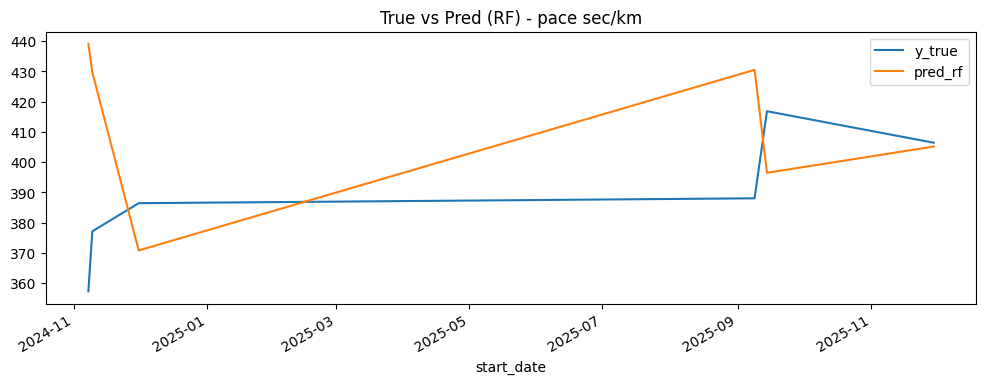

In [19]:
out.plot(x="start_date", y=["y_true","pred_rf"], figsize=(12,4), title="True vs Pred (RF) - pace sec/km")

Feature importance (RF)

<Axes: title={'center': 'RF Feature importances (top 20)'}>

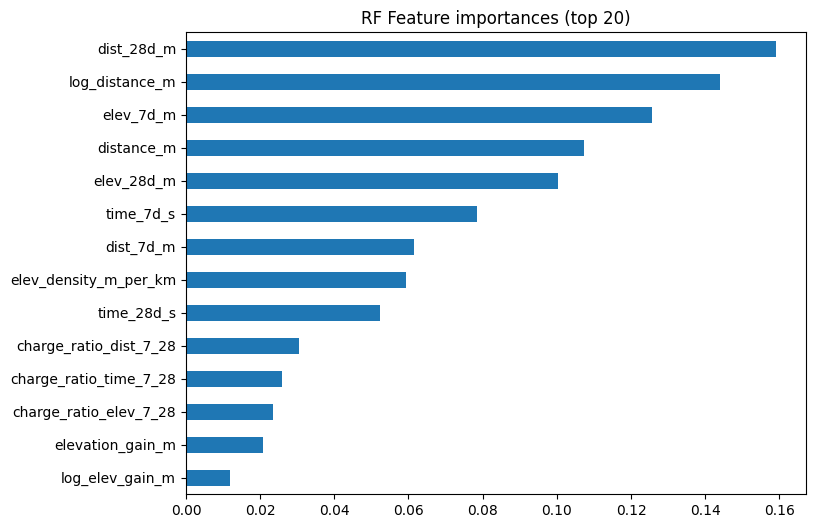

In [20]:
imp = pd.Series(rf.feature_importances_, index=FEATURES).sort_values()
imp.tail(20).plot(kind="barh", figsize=(8,6), title="RF Feature importances (top 20)")


Exemple “prédire une nouvelle sortie”

In [21]:
# exemple: tu veux prédire la dernière sortie du dataset test
x_one = X_test.iloc[[-1]]
pred = rf.predict(x_one)[0]
print("Predicted pace:", pred, "=>", pretty_pace(pred))


Predicted pace: 405.1764439907589 => 6:45/km


J’utilise MAE comme métrique principale car elle est directement interprétable en secondes par kilomètre, et RMSE pour pénaliser davantage les grosses erreurs.

À partir des seules données Strava agrégées, j’ai construit un modèle de prédiction d’allure avec un split temporel.
Le modèle Random Forest atteint une erreur moyenne d’environ 36 secondes par kilomètre, ce qui montre que la charge récente et le dénivelé expliquent une part significative de la performance, même sans données physiologiques.